In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision.utils import save_image
from torchsummary import summary
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
class COVID_CT(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)
    
    def summery(self, input_size):
        return summary(self, input_size)

In [4]:
model = COVID_CT(num_classes=3).to(device)
model.summery((3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [5]:
PATH = '../models/covid_ct_resnet_checkpoint.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

COVID_CT(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [6]:
Folders = ['1NonCOVID', '2COVID', '3CAP']
# stats = (0.5,), (0.5,)
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
size = 224
batch_size=128
channels = 3

transformer = T.Compose([
    T.Resize(size), 
    T.CenterCrop(size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [7]:
dataset = ImageFolder('../images/', transform=transformer)
len(dataset), dataset.classes

(3, ['1NONCOVID', '2COVID', '3CAP'])

In [8]:
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
def denorm(image, stats=stats):
    return image * stats[1] + stats[0]

In [10]:
def show_image(img, title=None):
    """ visualize torch tensor image """
    img = img.numpy().transpose(1, 2, 0)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = img * std + mean
    img = np.clip(img, 0, 1)
    plt.axis('off')
    plt.imshow(img)
    if title:
        plt.title(title, color='green')

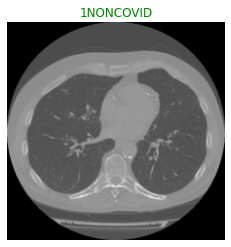

In [14]:
idx = 0
img, lbl = dataset[idx]
show_image(img, title=dataset.classes[lbl])

In [15]:
out = model(img.unsqueeze(0))
out.size(), out

(torch.Size([1, 3]),
 tensor([[ 6.3179, -4.3053, -1.3781]], grad_fn=<AddmmBackward0>))

In [16]:
torch.max(out, dim=1)

torch.return_types.max(
values=tensor([6.3179], grad_fn=<MaxBackward0>),
indices=tensor([0]))

In [36]:
model.network.layer4[2].bn2

AttributeError: 'MobileNetV2' object has no attribute 'layer4'

In [15]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp


In [16]:
target_layer = [model.network.layer4[-1]]
target_layer = model.network.layer4[2].bn2

In [17]:
gradcam = GradCAM(model, target_layer)
gradcam_pp = GradCAMpp(model, target_layer)

mask, _ = gradcam(img.unsqueeze(0))
heatmap, result = visualize_cam(mask, img)

/Users/pejman/miniforge3/envs/py39/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/Users/pejman/miniforge3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [18]:
mask_pp, _ = gradcam_pp(img.unsqueeze(0))
heatmap_pp, result_pp = visualize_cam(mask_pp, img)

In [19]:
result.size()

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


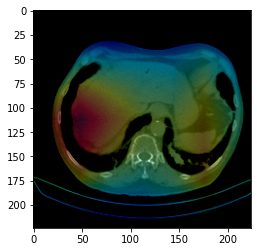

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


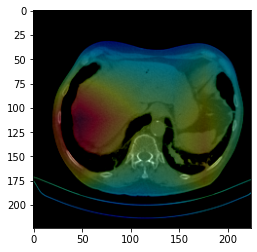

In [20]:
plt.imshow(result_pp.permute(1, 2, 0))
plt.show()
plt.imshow(result.permute(1, 2, 0))

In [21]:
save_image(result, '../images/results.png')

# MobileNet_V2

In [22]:
class COVID_CT_MobileNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.mobilenet_v2(pretrained=True)
        # Replace last layer
        self.network.classifier[1] = nn.Linear(self.network.classifier[1].in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)
    
    def summery(self, input_size):
        return summary(self, input_size)
    
    def _load_model_(self, path, device):
        self.load_state_dict(torch.load(path, map_location=device))

model = COVID_CT_MobileNet(num_classes=3).to(device)
model._load_model_('../models/covid_ct_mobile_checkpoint.pth', device)
model.summery((3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [23]:
model

COVID_CT_MobileNet(
  (network): MobileNetV2(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(

In [24]:
target_layer = model.network.features[-1][-1]

In [25]:
gradcam = GradCAM(model, target_layer)
gradcam_pp = GradCAMpp(model, target_layer)

mask, _ = gradcam(img.unsqueeze(0))
heatmap, result = visualize_cam(mask, img)

In [26]:
mask_pp, _ = gradcam_pp(img.unsqueeze(0))
heatmap_pp, result_pp = visualize_cam(mask_pp, img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


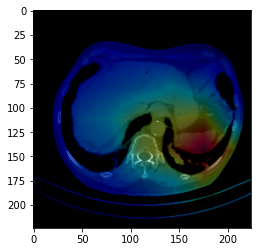

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


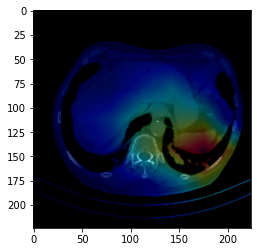

In [27]:
plt.imshow(result_pp.permute(1, 2, 0))
plt.show()
plt.imshow(result.permute(1, 2, 0))